In [1]:
%load_ext autoreload
%autoreload 2
    
import pandas as pd
import numpy as np

import patsy
import pystan
print(pystan.__version__)

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

2.17.1.0


In [2]:
SEED = 123
DRAWS = 5000
BURNIN = 1000
#TUNE = 2000
CHAINS = 4
#CORES = 2

In [3]:
sleep = pd.read_csv('../datasets/sleepstudy.csv', index_col=0)
sleep['Subject'] = pd.Categorical(sleep['Subject'], ordered=False)
sleep.head()

,Reaction,Days,Subject
1,249.5600,0,308
2,258.7047,1,308
3,250.8006,2,308
4,321.4398,3,308
5,356.8519,4,308


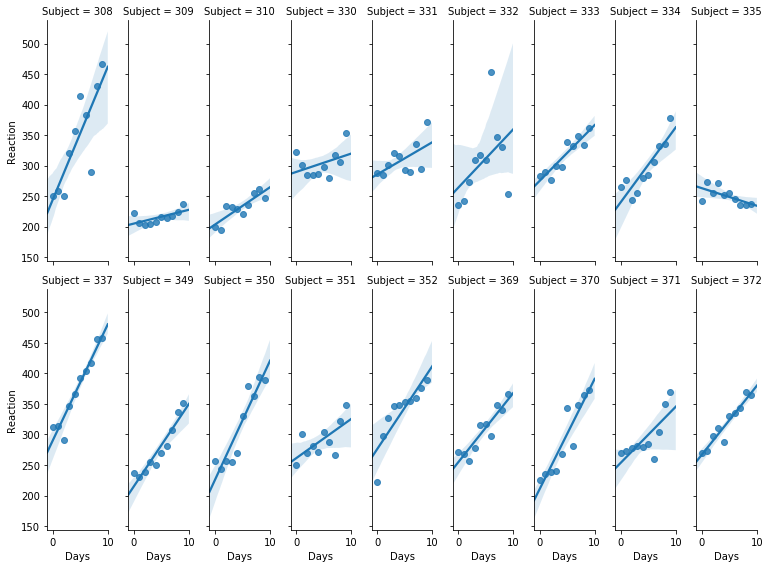

In [4]:
sns.lmplot(x="Days", y="Reaction", col="Subject", data=sleep, col_wrap=9, palette="muted", aspect=0.3, size=4)

In [5]:
X = patsy.dmatrix("1 + Days", data=sleep, return_type='dataframe')
X = np.asarray(X)
X.shape

(180, 2)

In [6]:
Z_intercept = patsy.dmatrix('0 + Subject', data=sleep, return_type='dataframe')
Z_intercept = np.asarray(Z_intercept)

Z_slope = patsy.dmatrix('0 + Subject:Days', data=sleep, return_type='dataframe')
Z_slope = np.asarray(Z_slope)

Z = np.concatenate((Z_intercept, Z_slope), axis=1)
Z.shape

(180, 36)

In [7]:
Y = np.asarray(sleep['Reaction'])
Y.shape

(180,)

In [8]:
stan_code = """

data {
    int<lower=0> n_fixed_effects;
    int<lower=0> n_subjects;
    int<lower=0> n_observations;
    int<lower=0> n_random_effects;
    
    
    vector [n_observations] Y; // observations
    
    matrix [n_observations, n_fixed_effects] X; // design matrix for fixed effects
    matrix [n_observations, n_subjects*n_random_effects] Z; // design matrix for random effects  
}

parameters {
    vector<lower=0>[1] beta_X_intercept;
    vector[1] beta_X_slope;

    vector[n_subjects] gamma_Z_intercept_raw;
    real<lower=0> scaler_Z_intercept;

    vector[n_subjects] gamma_Z_slope_raw;
    real<lower=0> scaler_Z_slope;

    real<lower=0> sigma_unexplained;
}

transformed parameters {
    vector [n_subjects] gamma_Z_intercept;
    vector [n_subjects] gamma_Z_slope;

    gamma_Z_intercept = gamma_Z_intercept_raw * scaler_Z_intercept;
    gamma_Z_slope = gamma_Z_slope_raw * scaler_Z_slope;
}

model {
    vector [n_fixed_effects] beta_X;
    vector [n_subjects*n_random_effects] gamma_Z;
    
    beta_X = append_row(beta_X_intercept, beta_X_slope);
    gamma_Z = append_row(gamma_Z_intercept, gamma_Z_slope);
    
    beta_X_intercept ~ normal(0, 10000);
    beta_X_slope ~ normal(0, 100);

    scaler_Z_intercept ~ normal(0, 100);
    scaler_Z_slope ~ normal(0, 100);
    
    gamma_Z_intercept_raw ~ normal(0, 1);
    gamma_Z_slope_raw ~ normal(0, 1);
    
    sigma_unexplained ~ normal(0, 100);
    Y ~ normal(X * beta_X + Z * gamma_Z, sigma_unexplained);
}

"""

In [9]:
stan_model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d196cc325aabefff4d0c08ac619a590a NOW.


In [10]:
stan_data = {
    'n_fixed_effects': X.shape[1],
    'n_subjects': Z_intercept.shape[1],
    'n_random_effects': X.shape[1], 
    'n_observations': Y.shape[0],
    'Y': Y,
    'X': X,
    'Z': Z}

In [11]:
stan_fit = stan_model.sampling(data=stan_data, chains=4, iter=DRAWS+BURNIN, warmup=BURNIN, seed=SEED)

In [12]:
print(stan_fit)

Inference for Stan model: anon_model_d196cc325aabefff4d0c08ac619a590a.
4 chains, each with iter=6000; warmup=1000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

                            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta_X_intercept[1]       251.32    0.08   7.46  236.5 246.56  251.3 256.18 266.02   8342    1.0
beta_X_slope[1]            10.45    0.02    1.7   7.04   9.34  10.46  11.56  13.77   6946    1.0
gamma_Z_intercept_raw[1]    0.05  3.9e-3   0.53   -1.0   -0.3   0.06   0.41    1.1  18872    1.0
gamma_Z_intercept_raw[2]   -1.53  4.4e-3   0.56  -2.69  -1.89  -1.52  -1.15  -0.48  16665    1.0
gamma_Z_intercept_raw[3]   -1.49  4.4e-3   0.56  -2.63  -1.86  -1.47  -1.11  -0.44  15914    1.0
gamma_Z_intercept_raw[4]    0.95  4.1e-3   0.55  -0.11   0.58   0.94    1.3   2.07  17912    1.0
gamma_Z_intercept_raw[5]    0.88  4.1e-3   0.54  -0.14   0.51   0.86   1.23   1.98  17613    1.0
gamma_Z_intercept_raw[6]    0.35  

In [13]:
trace = stan_fit.extract(permuted=True)

In [14]:
def plot_trace(trace):
    trace_var = [key for key in trace.keys() if 'lp__' not in key]
    
    fig, ax = plt.subplots(nrows=len(trace_var), ncols=2, figsize=(10, 10), constrained_layout=True)   
    
    for axi, var in enumerate(trace_var):
        if len(trace[var].shape) == 1:
            trace[var] = trace[var].reshape(-1, 1)
            
        for vari in trace[var].T:
            sns.kdeplot(vari, ax=ax[axi, 0])
        
        ax[axi, 1].plot(trace[var], alpha=0.5)
        
        ax[axi, 0].set_title(var)
        ax[axi, 1].set_title(var)
        
        ax[axi, 0].set_ylabel('frequency')
        ax[axi, 0].yaxis.set_label_coords(-0.15, 0.5)
        ax[axi, 1].set_ylabel('sample value')
        ax[axi, 1].yaxis.set_label_coords(-0.12, 0.5)


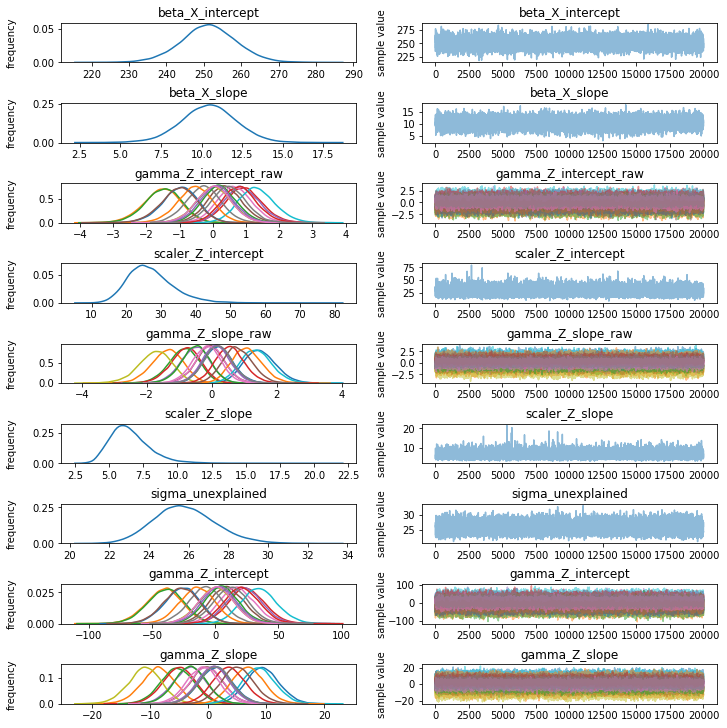

In [15]:
plot_trace(trace)